In [1]:
!pip install anndata
!pip install scanpy
!pip install decoupler

In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('GTEX-1HSMQ-5005.h5ad')

In [4]:
!wget -O GTEX-1HSMQ-5005.h5ad  "https://drive.usercontent.google.com/download?id=1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9&export=download&authuser=0&confirm=t&uuid=b3f632b6-8dd3-4cbe-aade-886aad76299c&at=APZUnTV6ape4OEBvDGLvCmNBfgp0%3A1714034617680"

--2024-05-08 13:17:19--  https://drive.usercontent.google.com/download?id=1MZ6HmqiCeN5mJd2cYM498PgnNOV8goQ9&export=download&authuser=0&confirm=t&uuid=b3f632b6-8dd3-4cbe-aade-886aad76299c&at=APZUnTV6ape4OEBvDGLvCmNBfgp0%3A1714034617680
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 209.85.145.132, 2607:f8b0:4001:c1e::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|209.85.145.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444294630 (424M) [application/octet-stream]
Saving to: ‘GTEX-1HSMQ-5005.h5ad’

GTEX-1HSMQ-5005.h5a 100%[===================>] 423.71M  82.5MB/s    in 5.0s    

2024-05-08 13:17:25 (85.1 MB/s) - ‘GTEX-1HSMQ-5005.h5ad’ saved [444294630/444294630]



In [5]:
adata = ad.read_h5ad('GTEX-1HSMQ-5005.h5ad')
adata

AnnData object with n_obs × n_vars = 14404 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', 'A

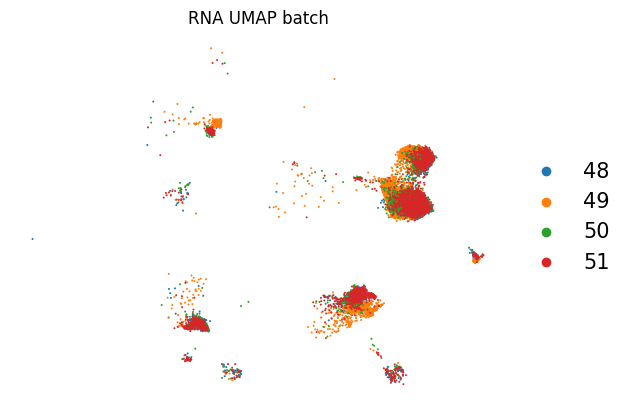

In [6]:
sc.pl.umap(adata, color='batch', title='RNA UMAP batch', frameon=False, legend_fontweight='normal', legend_fontsize=15)

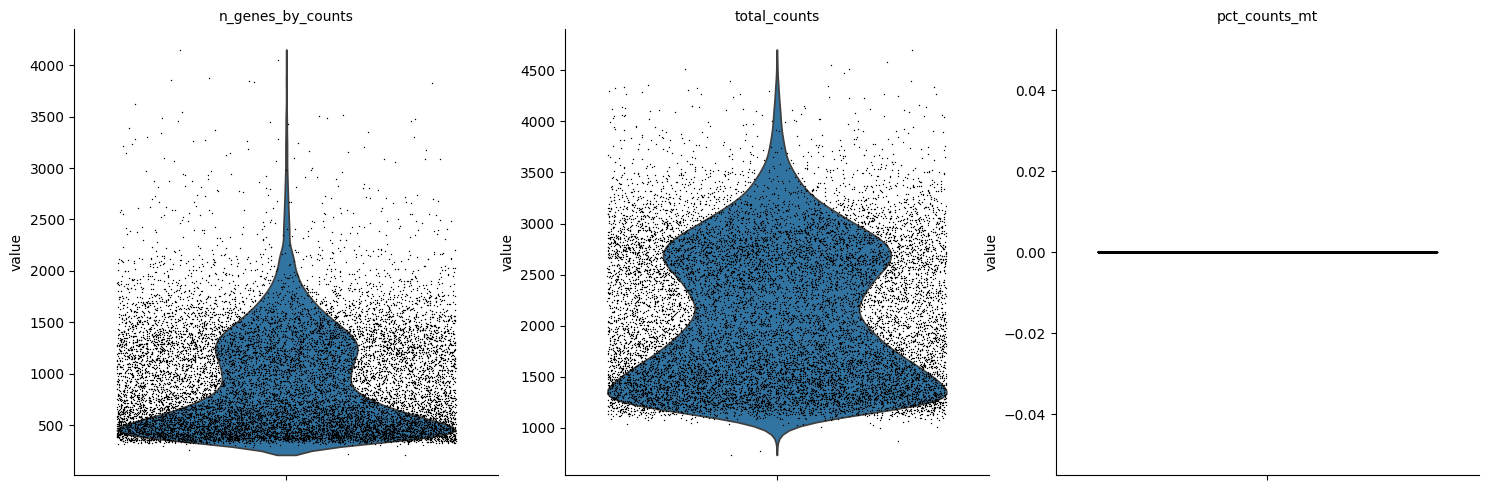

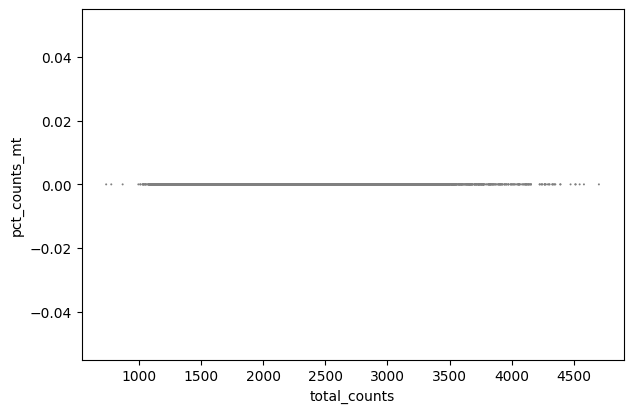

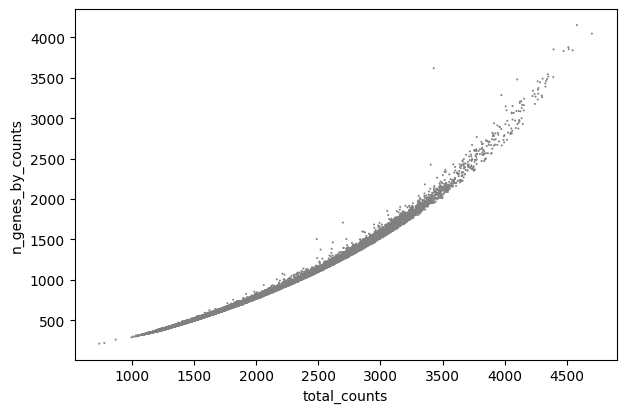

AnnData object with n_obs × n_vars = 14404 × 16803
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', '

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")
adata

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
non_normalized_adata=adata.copy()

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [11]:
!pip install leidenalg

<ipython-input-12-a4a2c756c9b4>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.03)


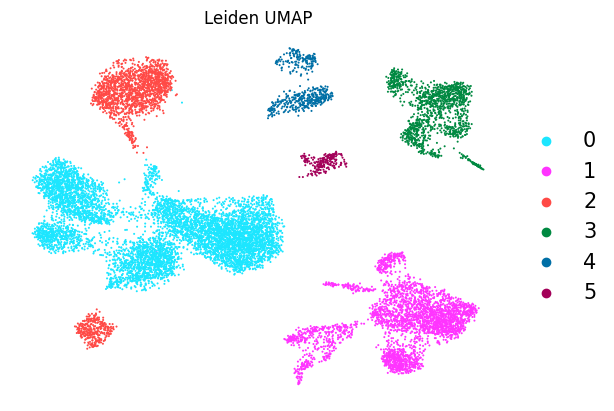

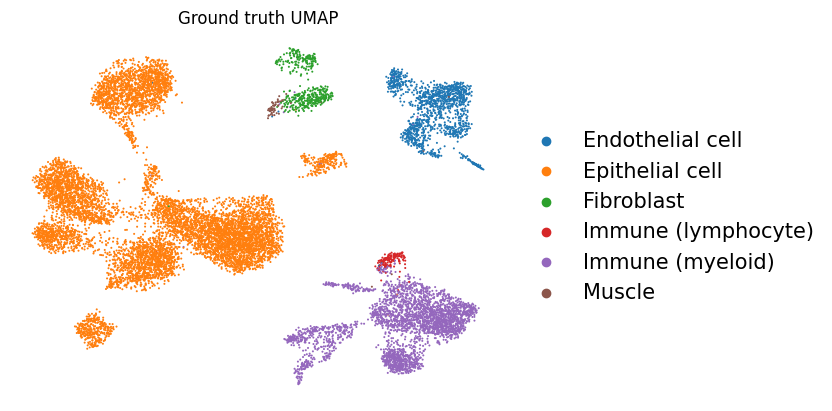

In [12]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.03)

sc.pl.umap(adata, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(adata, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [13]:
print(adata.obs['leiden'].values)

['1', '0', '5', '0', '0', ..., '0', '1', '0', '3', '0']
Length: 13990
Categories (6, object): ['0', '1', '2', '3', '4', '5']


In [14]:
from sklearn.metrics import davies_bouldin_score

labels=adata.obs['leiden'].values
print(labels)

db_score=davies_bouldin_score(adata.X.toarray(),labels)

['1', '0', '5', '0', '0', ..., '0', '1', '0', '3', '0']
Length: 13990
Categories (6, object): ['0', '1', '2', '3', '4', '5']


In [15]:
print(db_score)

7.04139114158685


In [16]:
print(adata)

AnnData object with n_obs × n_vars = 13990 × 16803
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', '

In [17]:
print(non_normalized_adata)

AnnData object with n_obs × n_vars = 13990 × 16803
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', '

In [18]:
sc.pp.highly_variable_genes(non_normalized_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pp.scale(non_normalized_adata, max_value=10)

sc.tl.pca(non_normalized_adata, svd_solver='arpack')


sc.pp.neighbors(non_normalized_adata, n_neighbors=10, n_pcs=40)


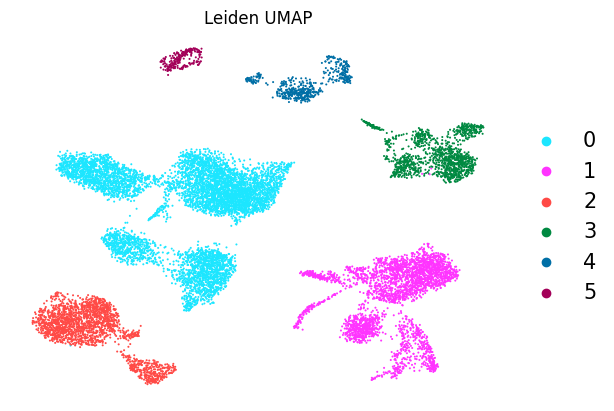

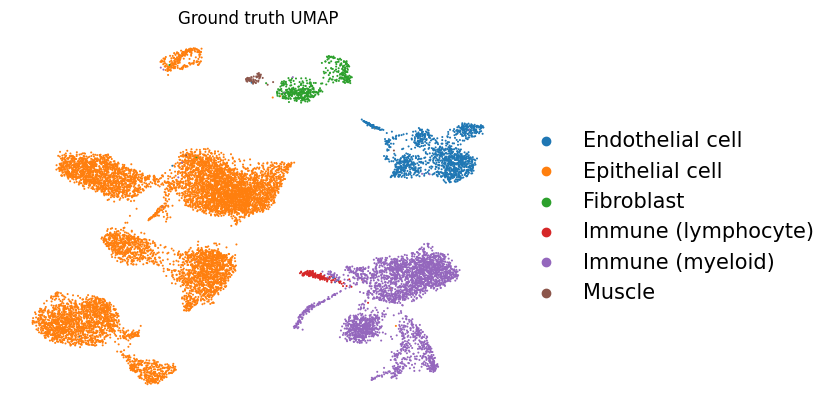

In [23]:
sc.tl.umap(non_normalized_adata)
sc.tl.leiden(non_normalized_adata, resolution=0.02)

sc.pl.umap(non_normalized_adata, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(non_normalized_adata, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [24]:
non_normalized_labels=non_normalized_adata.obs['leiden'].values

non_normalized_db_score=davies_bouldin_score(non_normalized_adata.X,non_normalized_labels)
print(non_normalized_db_score)

9.004481904448305


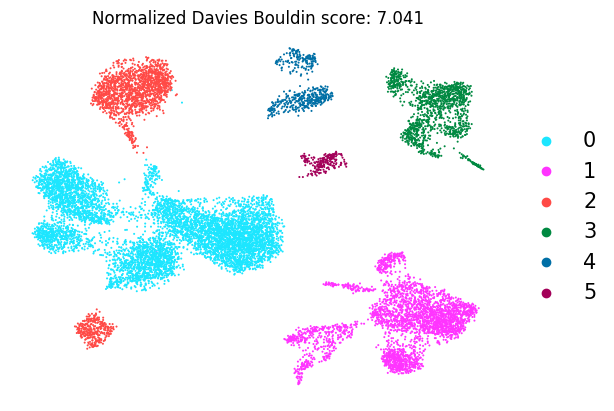

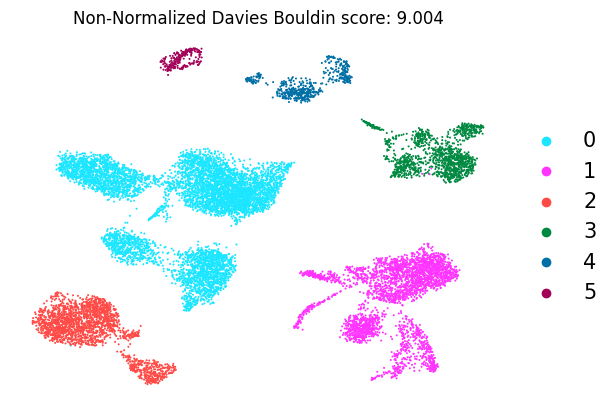

In [25]:
sc.pl.umap(adata, color='leiden', title=f"Normalized Davies Bouldin score: {round(db_score,3)}",
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(non_normalized_adata, color='leiden', title=f"Non-Normalized Davies Bouldin score: {round(non_normalized_db_score,3)}",
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

Conclusion:
Davies Bouldin score is metric which measures size of clusters against the average distnce between clusters, and lower score means that the clusters are better defined. Taking that into account, conclusion is that normalized data brings more accurate and better results, as expected.